In [4]:
import torch
from torch import nn
import pandas as pd
from collections import Counter
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda:0")

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LanguageModel, self).__init__()
        self.embeddedLayer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,  batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x):
        x = self.embeddedLayer(x)
        lstm_out, (hn, cn) = self.lstm(x)
        output = self.fc(lstm_out)
        return output

model.to(device)

input_text = "If life gives you melons"

input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

model.eval()

output_ids = model.generate(
    input_ids=input_ids,
    max_length=100,
    temperature=0.7,
    top_k=50,
    top_p=0.95,
    num_return_sequences=10,
    do_sample=True
)

for output in output_ids:
    output_text = tokenizer.decode(output, skip_special_tokens=True)
    print(output_text)




We have added 1 tokens


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/tmp/ipykernel_2942118/3870043403.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_

If life gives you melons, make sure to have a melon for every day.
If life gives you melons, don't try to make melons.
If life gives you melons, you can always make up melons.
If life gives you melons, I give you a life of melons
If life gives you melons, don't eat them
If life gives you melons, you can always grow melons yourself
If life gives you melons, you can grow melons
If life gives you melons, you should try to find a place to eat them.
If life gives you melons, eat them. Life gives you melons, eat them.
If life gives you melons, eat them.


In [28]:
import os
import pandas as pd
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset
class Jokesdataset(Dataset):
    '''
    This class builds the custom dataset for Dataloader
    '''
    def __init__(self,data,tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.eos_tok = "<|endoftext|>"
        self.data['Joke'] = self.data['Joke'].apply(lambda x: "JOKE:" + str(x) + self.eos_tok)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        joke = self.data.iloc[idx,1]
    
        inputs = self.tokenizer.encode_plus(
            joke,
            None,
            add_special_tokens = True,
            max_length = 64,
            pad_to_max_length = True
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {'ids':torch.tensor(ids,dtype=torch.long),
            'mask': torch.tensor(mask,dtype=torch.long),
            'target':torch.tensor(ids,dtype=torch.long)}
        
    def random_split_joke(self, idx):
        joke = joke = self.data.iloc[idx,1]
        words = joke.split()
        split_ratio = np.random.uniform(0.3, 0.7) 
        split_index = int(len(words) * split_ratio)
        return " ".join(words[:split_index]), joke

jokes = pd.read_csv("/home/scxzc2/project/jokGen/reddit-cleanjokes.csv") 

dataset = Jokesdataset(jokes,tokenizer)
dataloader = DataLoader(dataset,
                                batch_size=1,
                                shuffle=True,
                                num_workers=4)

In [14]:
input = dataset.__getitem__(11)["ids"]
input_t = tokenizer.decode(input, skip_special_tokens=True)
print(input_t)

JOKE:My girlfriend told me she was leaving me because I keep pretending to be a Transformer... I said, No, wait! I can change!


In [33]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')


def choose_from_top(probs, n=5):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

def predict(input_text, length_of_joke):
    joke_num = 0
    model.eval()
    with torch.no_grad():
        joke_finished = False
        while(not joke_finished):

            cur_ids = torch.tensor(tokenizer.encode('JOKE:' + input_text)).unsqueeze(0).to(device)

            for i in range(length_of_joke):
                outputs = model(cur_ids, labels=cur_ids)
                loss, logits = outputs[:2]
                softmax_logits = torch.softmax(logits[0,-1], dim=0) #Take the first(from only one in this case) batch and the last predicted embedding
                if i < 3:
                    n = 20
                else:
                    n = 3
                next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n) #Randomly(from the topN probability distribution) select the next word
                cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim = 1) # Add the last word to the running sequence

                if next_token_id in tokenizer.encode('<|endoftext|>'):
                    joke_finished = True
                    break
                
                
        output_list = list(cur_ids.squeeze().to('cpu').numpy())
        output_text = tokenizer.decode(output_list)

        return output_text



[nltk_data] Downloading package punkt to /home/scxzc2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from tqdm import tqdm
    

num = 0
total_belu = 0
for i in tqdm(range(10)):
    input, joke = dataset.random_split_joke(i)  
    
    input = input.replace("JOKE:", "")
    
    outputs = []
    for j in range(10):
        output = predict(input, 64)
        outputs.append(output)
        
    references = [[joke] for _ in range(len(outputs))]
    
    bleu_score = corpus_bleu(references, outputs)
    
    total_belu += bleu_score
    num = num + 1
    # print(bleu_score)

avg_score = total_belu / num
print(f"AVG BLEU score: {avg_score}")

/home/scxzc2/anaconda3/envs/pytorch/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


['JO', 'KE', ':', 'My', 'Ġgirlfriend', 'Ġtold', 'Ġme', 'Ġshe', 'Ġwas', 'Ġleaving', 'Ġme', 'Ġbecause', 'ĠI', 'Ġkeep', 'Ġpretending', 'Ġto', 'Ġbe', 'Ġa', 'ĠTrans', 'former', '...', 'ĠI', 'Ġsaid', ',', 'ĠNo', ',', 'Ġwait', '!', 'ĠI', 'Ġcan', 'Ġchange', '!', '<|endoftext|>']


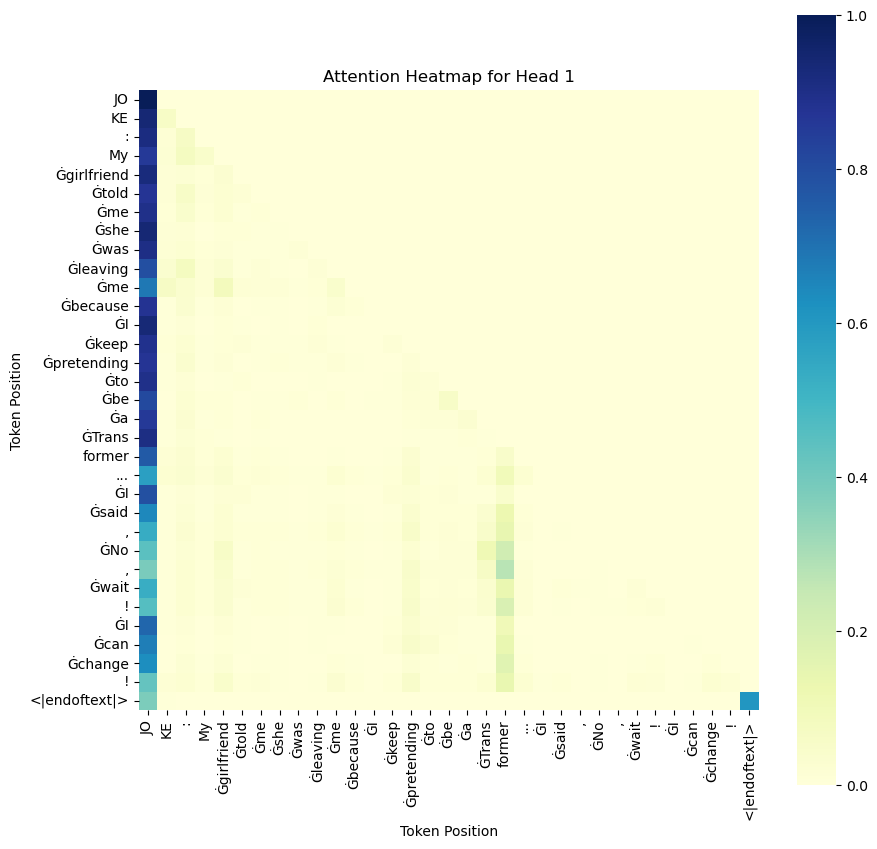

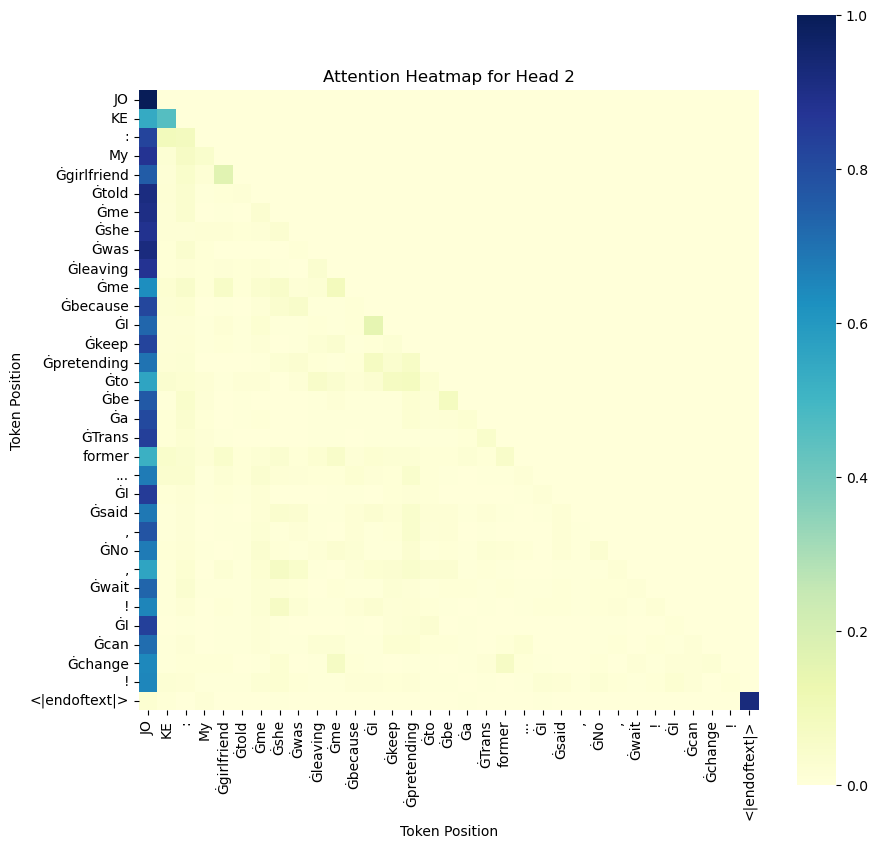

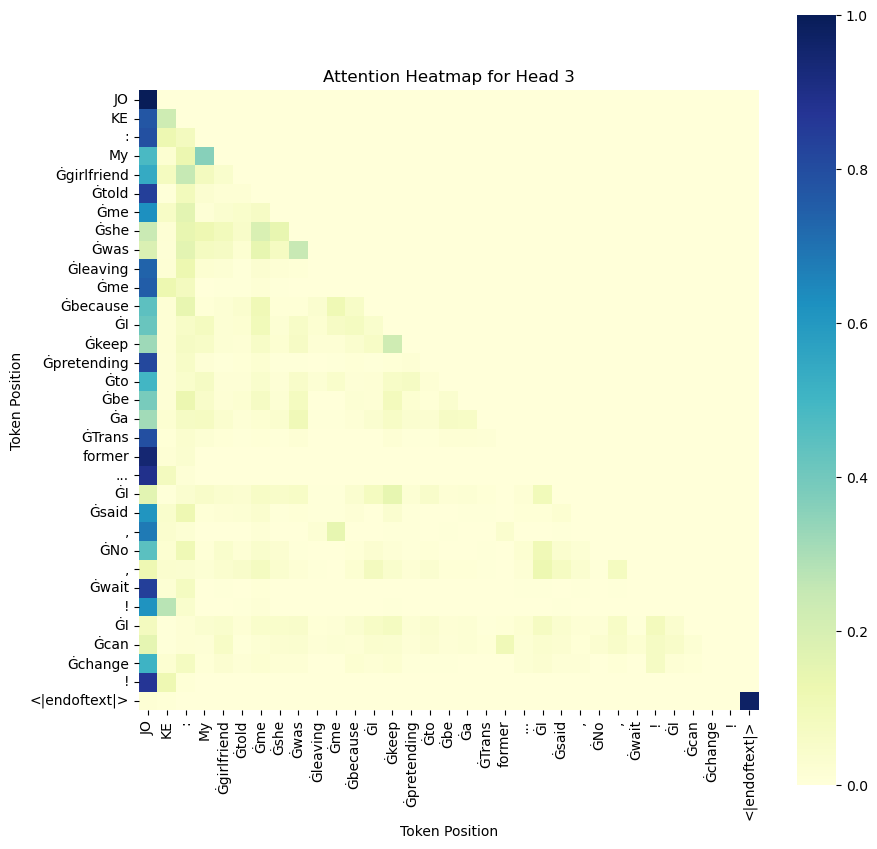

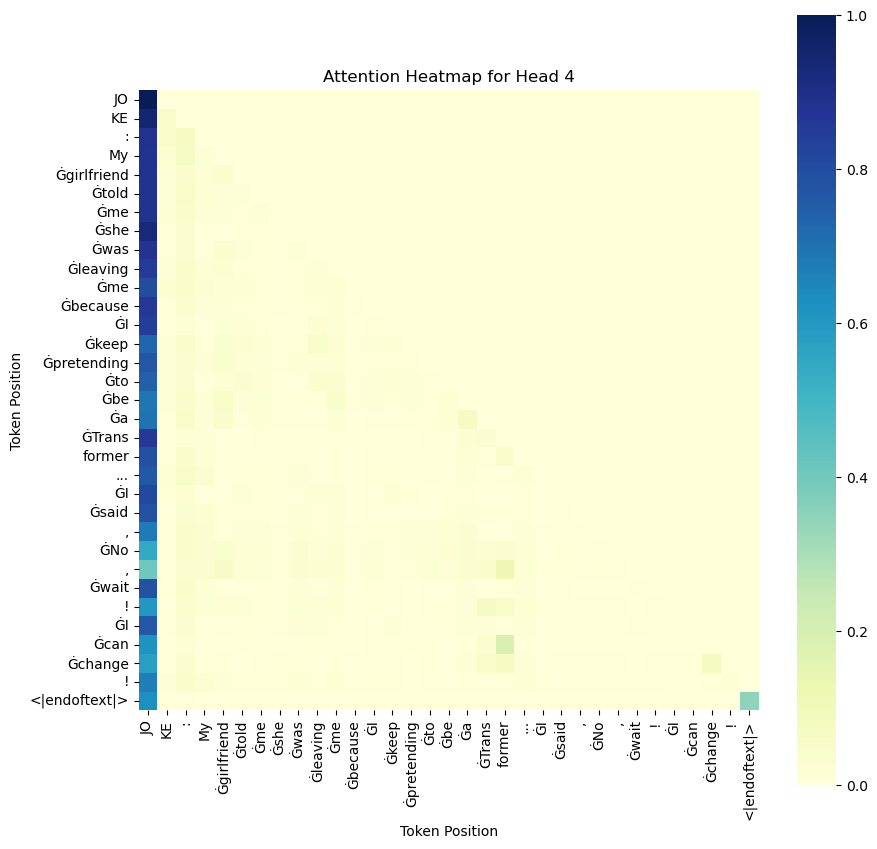

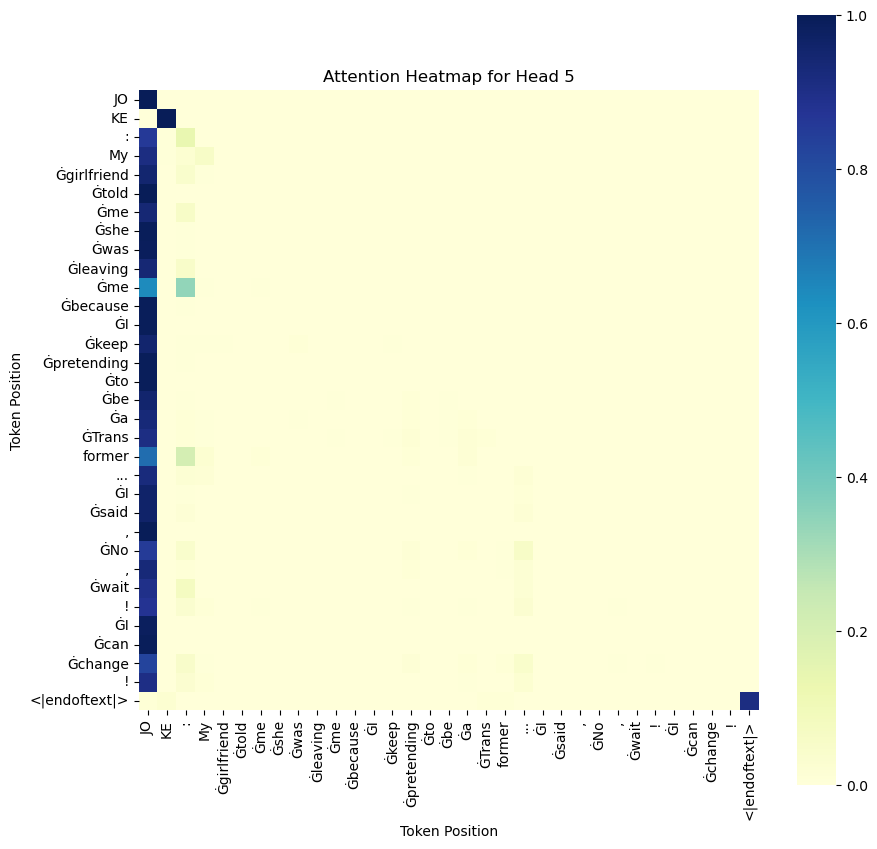

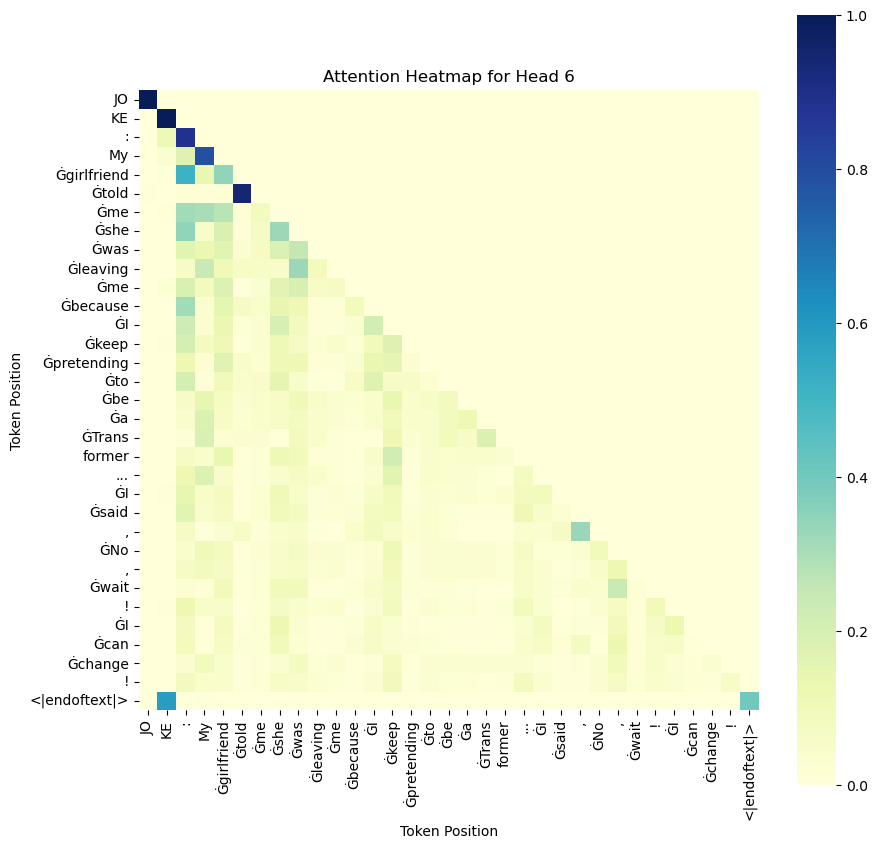

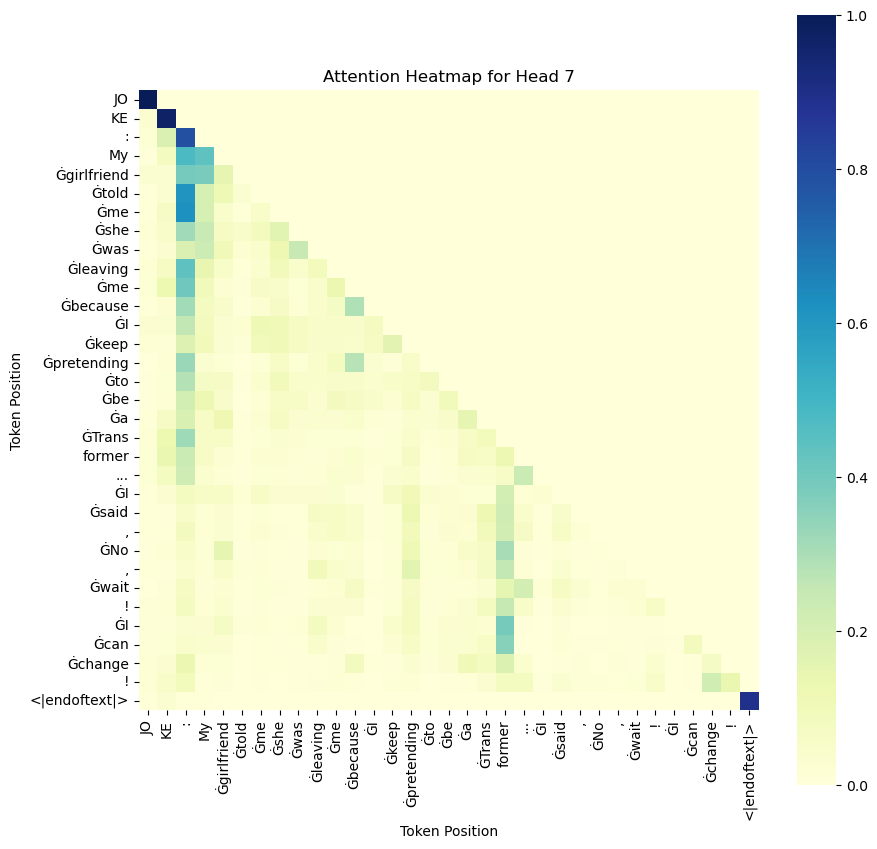

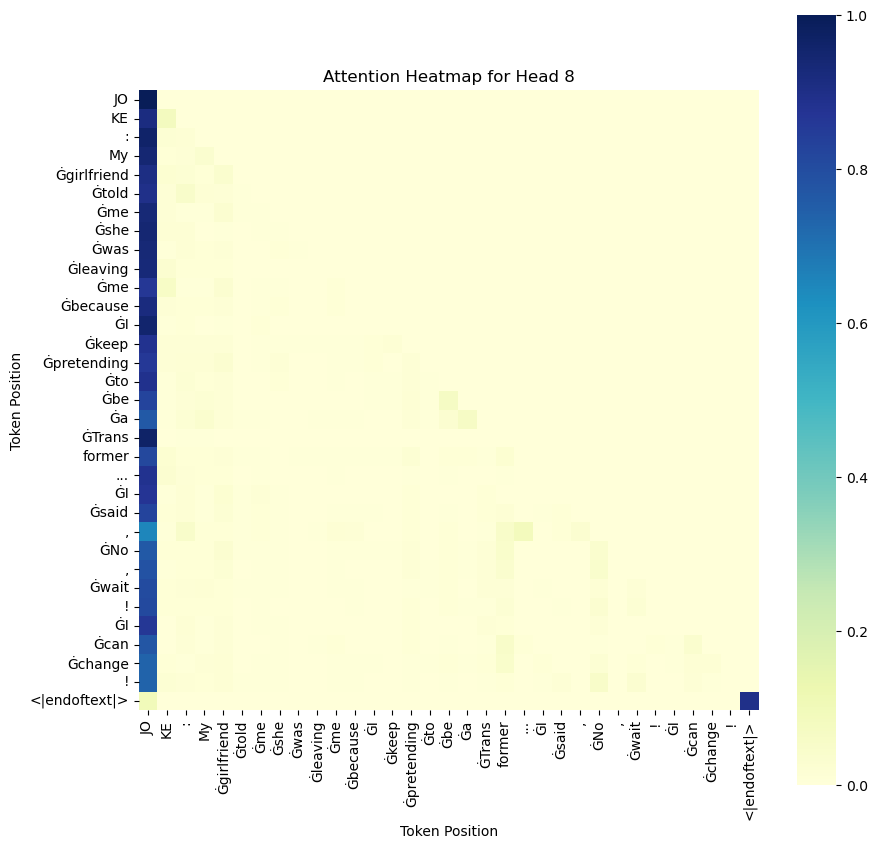

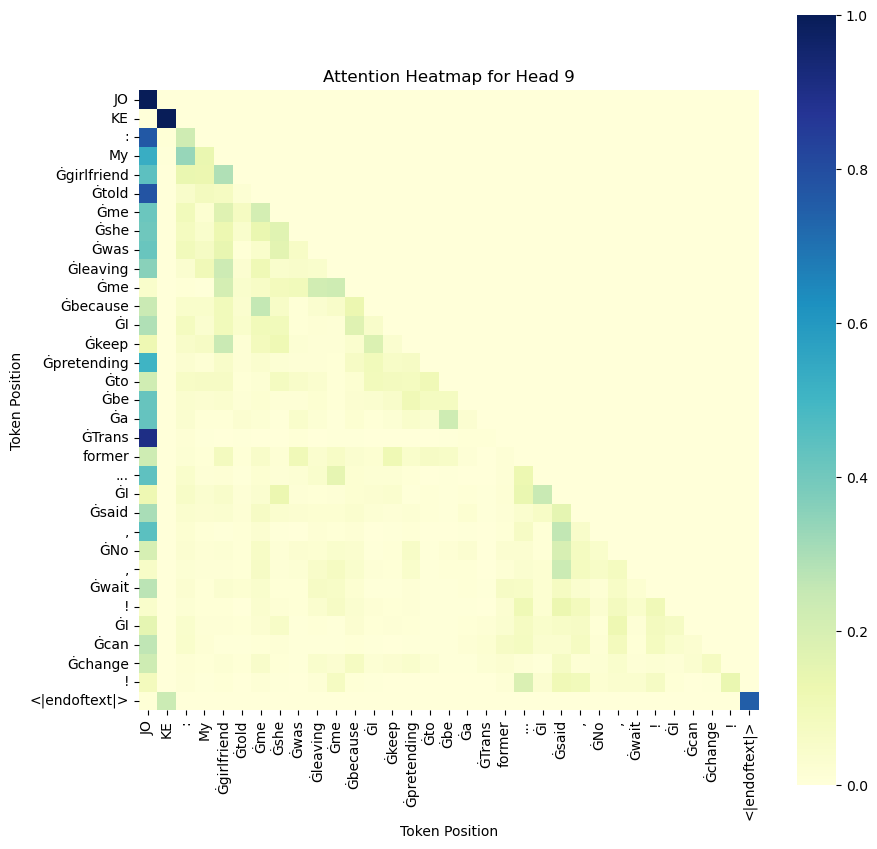

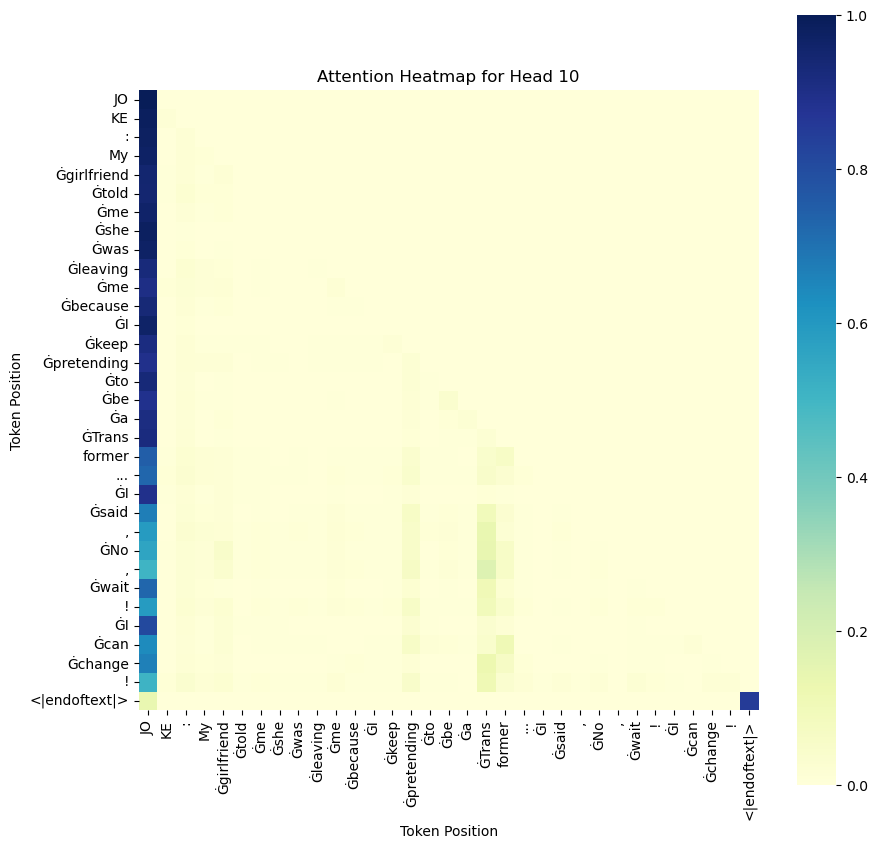

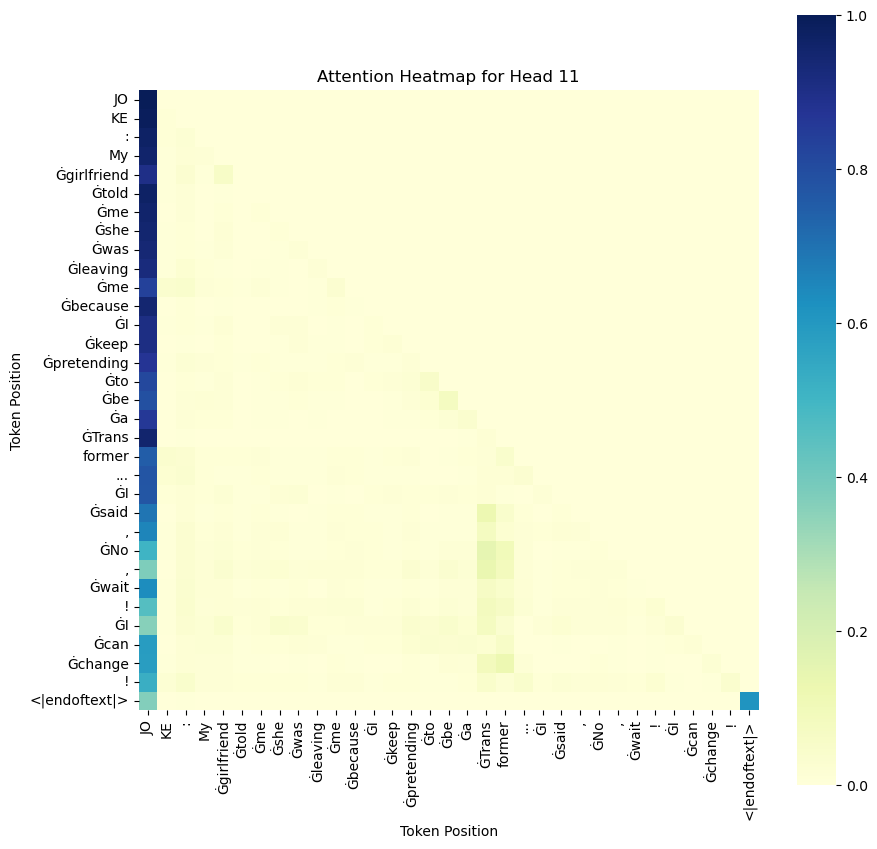

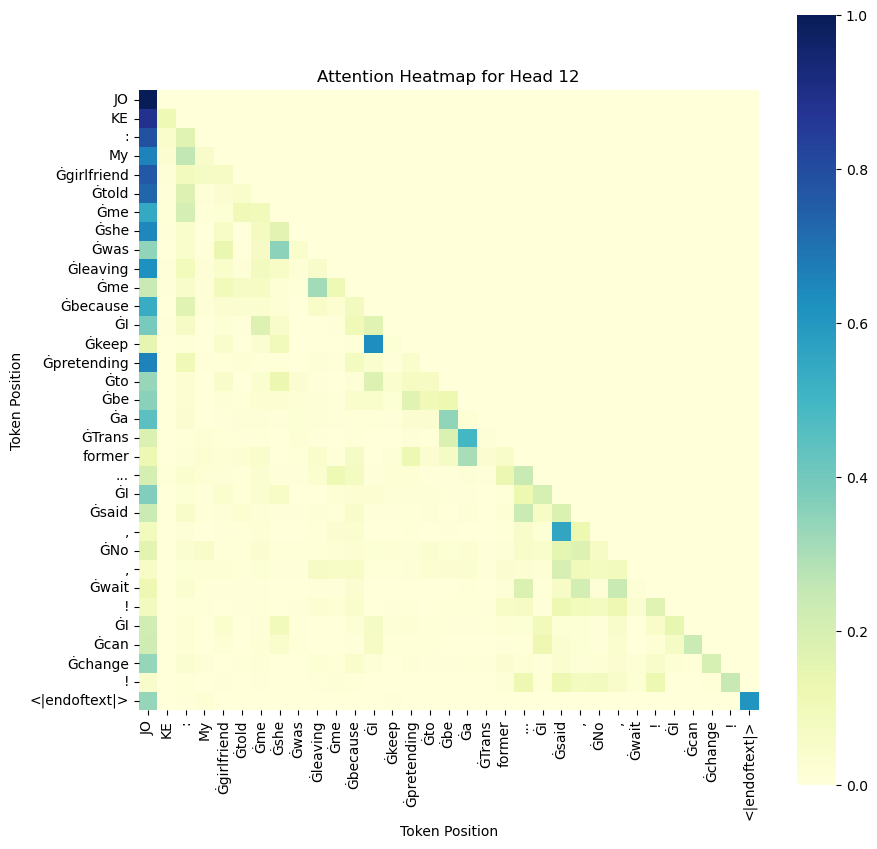

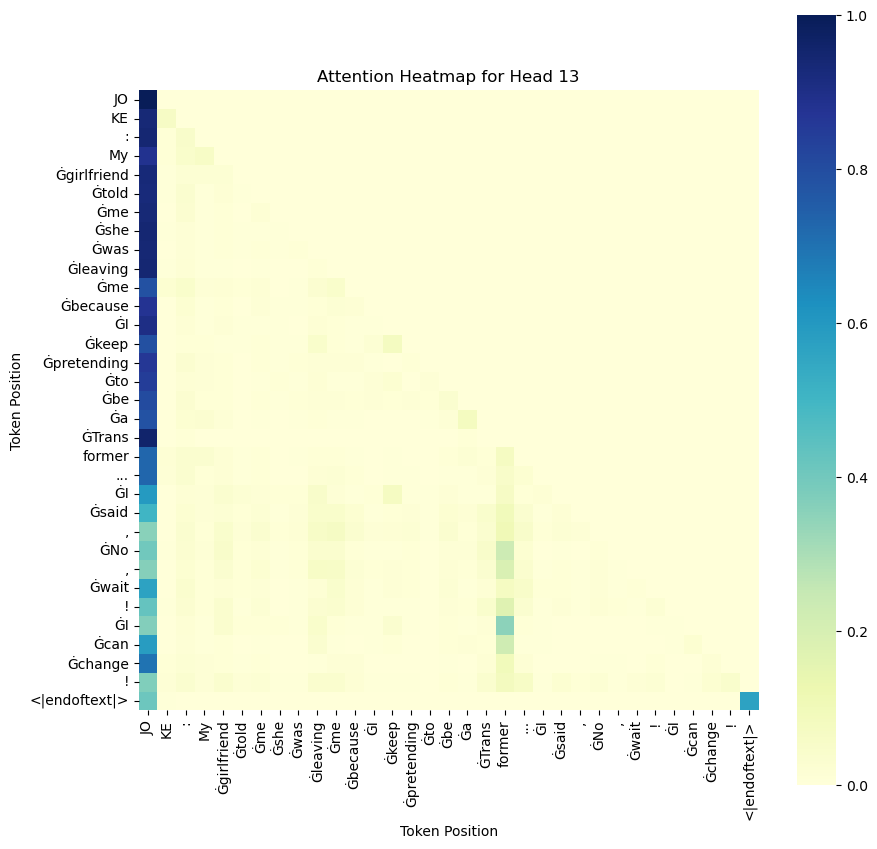

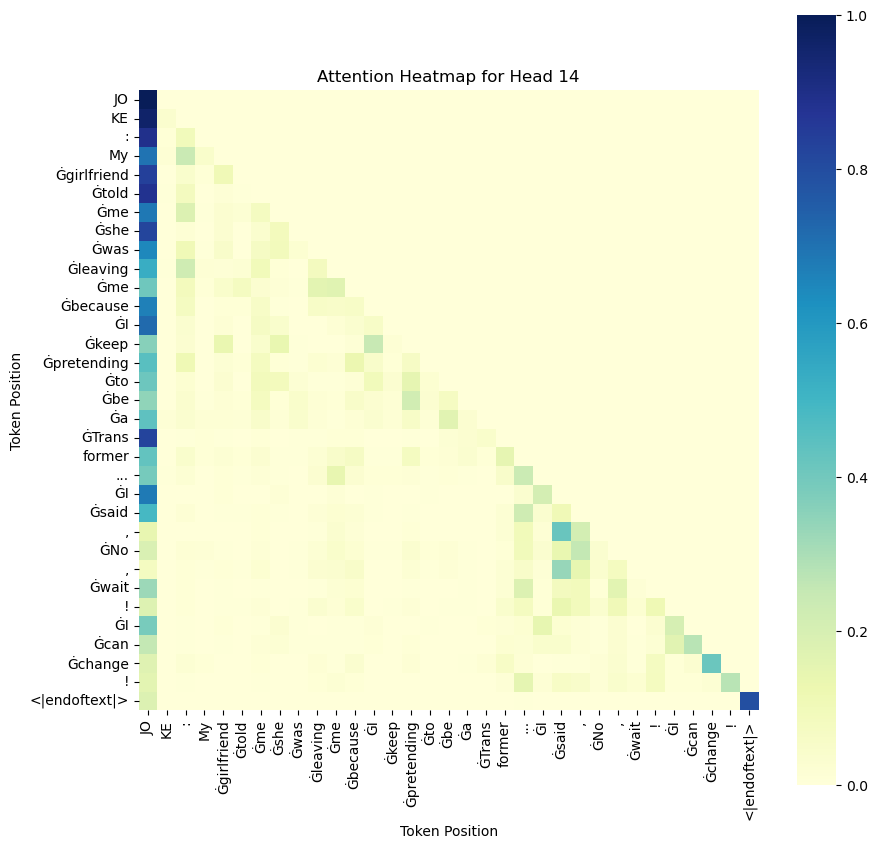

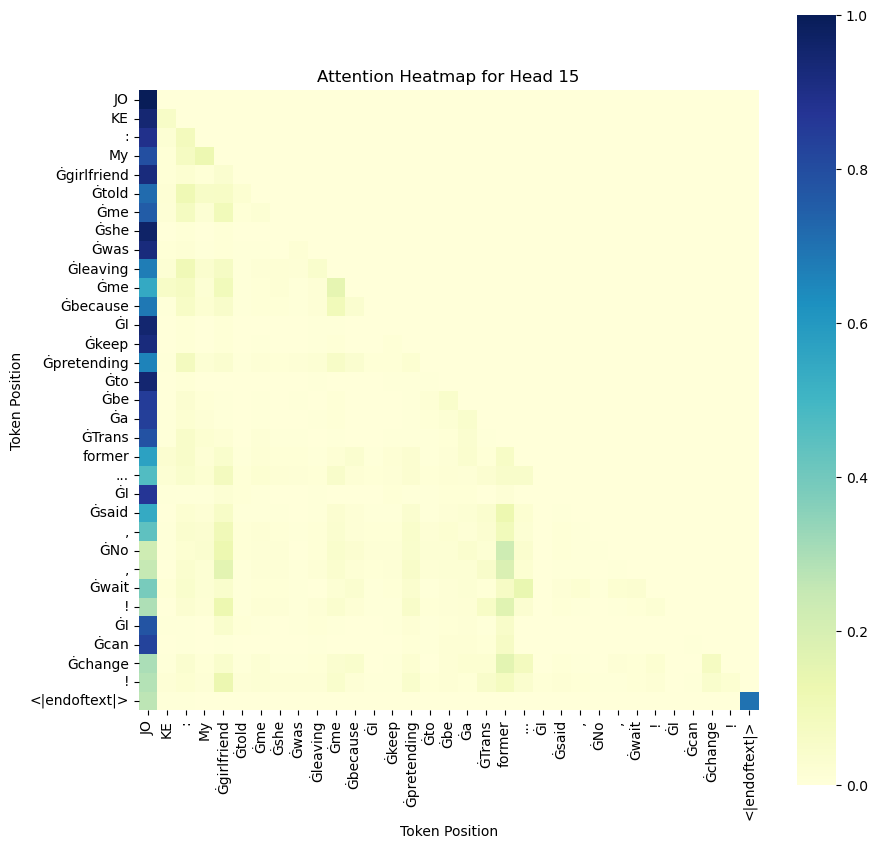

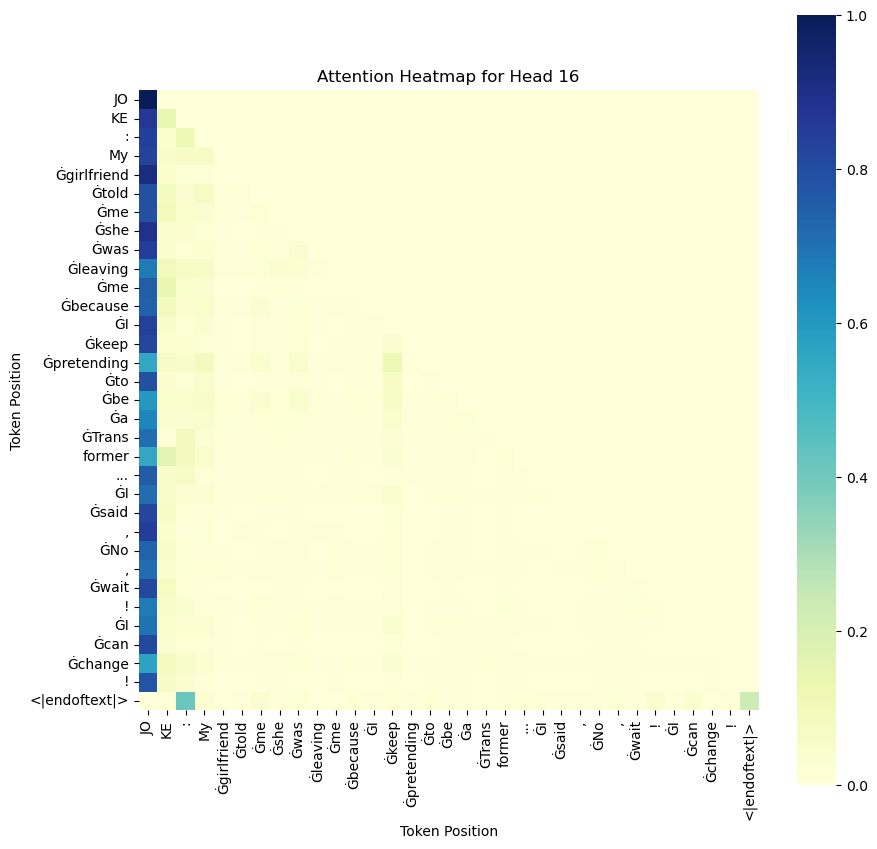

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(model, input_ids, attention_mask, tokenizer):
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_attentions=True
    )

    attentions = outputs.attentions 
    attention = attentions[-1] 
    attention = attention.squeeze(0).detach().cpu().numpy()  # (num_heads, seq_len, seq_len)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    attention_mask = attention_mask.squeeze().tolist()  

    valid_indices = [i for i, mask in enumerate(attention_mask) if mask == 1]
    filtered_tokens = [tokens[i] for i in valid_indices]
    print(filtered_tokens)
    attention = attention[:, valid_indices, :][:, :, valid_indices] 

    num_heads = attention.shape[0]
    for head in range(num_heads):
        plt.figure(figsize=(10, 10))
        sns.heatmap(
            attention[head],
            cmap="YlGnBu",
            xticklabels=filtered_tokens,
            yticklabels=filtered_tokens,
            square=True
        )
        plt.title(f"Attention Heatmap for Head {head + 1}")
        plt.xlabel("Token Position")
        plt.ylabel("Token Position")
        plt.xticks(rotation=90)
        plt.show()


d = dataset.__getitem__(11)
ids = d["ids"]
mask = d["mask"]
ids = ids.to(device, dtype=torch.long)
mask = mask.to(device, dtype=torch.long)
visualize_attention(model, ids, mask, tokenizer)